In [116]:
# Jake Mileham
# U21692492
# COS 711 A2

## Library Imports

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch as tch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from scipy import stats
import nbformat
from IPython import get_ipython
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Data preprocessing

In [137]:
df = pd.read_csv("Almond.csv")
df_features = df.copy()

# Create class dataframe
df_class = pd.DataFrame(df_features["Type"], columns=["Type"])

df_class.head()

# Remove unwanted features
df_features.drop(columns=["Unnamed: 0", "Type"], inplace=True)

# print(df_copy.isnull().sum())
# Split data into training and testing set
f_train, f_test, c_train, c_test = train_test_split(df_features, df_class, test_size=0.20, shuffle=True)

# Label encode Almond class

# MAMRA   = 0
# SANORA  = 1
# REGULAR = 2

c_train["Type"] = c_train["Type"].map(lambda type : 0 if type == "MAMRA" else 1 if type == "SANORA" else 2)
c_test["Type"] = c_test["Type"].map(lambda type : 0 if type == "MAMRA" else 1 if type == "SANORA" else 2)

#================================
# Fix dimensions of data
#================================

# Almond pictures were taken in different orientations
# L x W x H(Thickenss)
# Sort Descending then remove thickness columns
# L >= W

# Also add one hot encoding to indicate which dimension was missing

# Training

f_train["Length (major axis)"] = f_train["Length (major axis)"].fillna(-1)
f_train["Width (minor axis)"]  = f_train["Width (minor axis)"].fillna(-1)
f_train["Thickness (depth)"]   = f_train["Thickness (depth)"].fillna(-1)

f_train['L'] = (f_train['Length (major axis)'] == -1).astype(int)
f_train['W'] = (f_train['Width (minor axis)'] == -1).astype(int)
f_train['T'] = (f_train['Thickness (depth)'] == -1).astype(int)

train_temp = pd.DataFrame(f_train[["Length (major axis)", "Width (minor axis)", "Thickness (depth)"]].apply(lambda row: sorted(row, reverse=True), axis=1).tolist(), columns=["Length (major axis)", "Width (minor axis)", "Thickness (depth)"], index=f_train.index)

f_train["Length (major axis)"] = train_temp["Length (major axis)"]
f_train["Width (minor axis)"]  = train_temp["Width (minor axis)"]
f_train["Thickness (depth)"]   = train_temp["Thickness (depth)"]

# Testing

f_test["Length (major axis)"] = f_test["Length (major axis)"].fillna(-1)
f_test["Width (minor axis)"]  = f_test["Width (minor axis)"].fillna(-1)
f_test["Thickness (depth)"]   = f_test["Thickness (depth)"].fillna(-1)

f_test['L'] = (f_test['Length (major axis)'] == -1).astype(int)
f_test['W'] = (f_test['Width (minor axis)'] == -1).astype(int)
f_test['T'] = (f_test['Thickness (depth)'] == -1).astype(int)

test_temp = pd.DataFrame(f_test[["Length (major axis)", "Width (minor axis)", "Thickness (depth)"]].apply(lambda row: sorted(row, reverse=True), axis=1).tolist(), columns=["Length (major axis)", "Width (minor axis)", "Thickness (depth)"], index=f_test.index)

f_test["Length (major axis)"] = test_temp["Length (major axis)"]
f_test["Width (minor axis)"]  = test_temp["Width (minor axis)"]
f_test["Thickness (depth)"]   = test_temp["Thickness (depth)"]

# Remove thickness as a dimension, recalculate roundness using new dimension values

f_train.drop(columns=["Thickness (depth)"], inplace=True)
f_test.drop(columns=["Thickness (depth)"],  inplace=True)

f_train["Roundness"] = 4 * f_train["Area"] /  (np.pi * f_train["Length (major axis)"]**2) 
f_test["Roundness"] = 4 * f_test["Area"] /  (np.pi * f_test["Length (major axis)"]**2)

f_train["Aspect Ratio"] = f_train["Length (major axis)"] / f_train["Width (minor axis)"]
f_test["Aspect Ratio"] = f_test["Length (major axis)"] / f_test["Width (minor axis)"]

f_train["Eccentricity"] = np.sqrt(1 - (f_train["Width (minor axis)"] / f_train["Length (major axis)"])**2)
f_test["Eccentricity"] = np.sqrt(1 - (f_test["Width (minor axis)"] / f_test["Length (major axis)"])**2)

# Remove outliers - does not provide significant improvement

# train_temp = pd.concat([f_train, c_train], axis=1)
# test_temp  = pd.concat([f_test, c_test], axis=1)

# train_z_scores = np.abs(stats.zscore(train_temp))
# test_z_scores = np.abs(stats.zscore(test_temp))
# threshold = 3

# train_temp = train_temp[(train_z_scores < threshold).all(axis=1)]
# test_temp = test_temp[(test_z_scores < threshold).all(axis=1)]

# f_train = train_temp
# c_train = pd.DataFrame(f_train["Type"], columns=["Type"])
# f_train = f_train.drop(columns=["Type"])

# f_test = test_temp
# c_test = pd.DataFrame(f_test["Type"], columns=["Type"])
# f_test = f_test.drop(columns=["Type"])

# Scale features

# scalar = StandardScaler()
# f_train = scalar.fit_transform(f_train.values)
# f_test = scalar.fit_transform(f_test.values)

train_m = f_train.mean()
train_std = f_train.std()
f_train = (f_train - train_m) / train_std
f_test = (f_test - train_m) / train_std


f_train, f_valid, c_train, c_valid = train_test_split(f_train, c_train, test_size=0.20, shuffle=True)

# Convert to PyTorch Tensors
f_train = tch.tensor(f_train.values).float()
c_train = tch.tensor(c_train.values).long().flatten()
f_valid = tch.tensor(f_valid.values).float()
c_valid = tch.tensor(c_valid.values).long().flatten()
f_test  = tch.tensor(f_test.values).float()
c_test  = tch.tensor(c_test.values).long().flatten()



## Neural Network Class

In [155]:
class NeuralNetwork(nn.Module):
    def __init__(self, inputs: int, outputs: int, act_func: str):
        super(NeuralNetwork, self).__init__()

        self.epochs = 0
        self.training_loss = []
        self.training_accuracy = []
        self.valid_accuracy = []
        self.testing_accuracy = []

        self.layers = nn.Sequential(
            
            # Input Layer
            nn.Linear(inputs,64),
            nn.ReLU() if act_func == "ReLU" else nn.Tanh() if act_func == "Tanh" else nn.Sigmoid() if act_func == "Sigmoid" else nn.Softplus(beta=1, threshold=20) if act_func == "Softplus(beta = 1, threshold = 20)" else nn.LeakyReLU(negative_slope=0.01),
            # nn.Tanh(),

            # Hidden Layer
            nn.Linear(64,64),
            nn.ReLU() if act_func == "ReLU" else nn.Tanh() if act_func == "Tanh" else nn.Sigmoid() if act_func == "Sigmoid" else nn.Softplus(beta=1, threshold=20) if act_func == "Softplus(beta = 1, threshold = 20)" else nn.LeakyReLU(negative_slope=0.01),
            # nn.Tanh(),

            # Hidden Layer
            # nn.Linear(64,20),
            # nn.ReLU(),
            # nn.Tanh(),
            
            # Hidden Layer
            # nn.Linear(20,64),
            # nn.ReLU(),
            # nn.Tanh(),

            # Hidden Layer
            nn.Linear(64,64),
            nn.ReLU() if act_func == "ReLU" else nn.Tanh() if act_func == "Tanh" else nn.Sigmoid() if act_func == "Sigmoid" else nn.Softplus(beta=1, threshold=20) if act_func == "Softplus(beta = 1, threshold = 20)" else nn.LeakyReLU(negative_slope=0.01),
            # nn.Tanh(),

            # Output layer
            nn.Linear(64,outputs)
        )
        

    def forward(self, data):
        return self.layers(data)
    
    # def get_accuracy(prediction, target):
    #     count = 0
    #     for p in range(len(prediction)):
    #         value = max(prediction[p].numpy())
    #         count = count + 1 if target[p] == np.where(prediction[p]==value)[0][0] else count
    #     return count / target.size(0)
    
    def get_accuracy(self, prediction, target):
        target = target.numpy()
        prediction_indices = np.argmax(prediction.numpy(), axis=1)
        return np.sum(prediction_indices == target) / target.size
    
    def run(self, epochs = 500, lr = 0.001) -> float:
        self.training_loss = []
        self.validation_loss = []
        self.training_accuracy = []
        self.valid_accuracy = []
        self.testing_accuracy = []
        self.epochs = epochs
        self.optimiser = optim.Adam(self.parameters(), lr=lr)
        # optimiser = optim.Rprop(network.parameters(), lr=0.001)

        self.loss_func = nn.CrossEntropyLoss()
        # loss_func = nn.MSELoss()

        for epoch in range(self.epochs):
            # Pass Forward
            prediction = self.forward(f_train)
            loss = self.loss_func(prediction, c_train)
            # Back propogate and optimise
            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()

            with tch.no_grad():
                self.training_loss.append(loss.item())

                # Train accuracy
                self.training_accuracy.append(100 * self.get_accuracy(prediction, c_train))

                # Validation accuracy
                self.valid_accuracy.append(100 * self.get_accuracy(self.forward(f_valid), c_valid))
                self.validation_loss.append(self.loss_func(self.forward(f_valid), c_valid).item())
        with tch.no_grad():
            self.testing_accuracy.append(100 * self.get_accuracy(self.forward(f_test), c_test))
            return self.testing_accuracy[0] # Return final testing accuracy

    def display_metrics(self):

        print(f'Final Training Accuracy: {self.training_accuracy[-1]}')
        print(f'Final Validation Accuracy: {self.valid_accuracy[-1]}') 
        print(f'Final Testing Accuracy: {self.testing_accuracy[0]}')

        fig,ax = plt.subplots(2,1,figsize=(7,7))
        ax[0].plot(range(self.epochs), self.training_loss, label="Training Loss")
        ax[0].plot(range(self.epochs), self.validation_loss, label="Validation loss")
        ax[0].set_xlabel("Epoch Count")
        ax[0].set_ylabel("Loss")
        ax[0].set_title("Entropy Loss")
        ax[1].plot(range(self.epochs), self.training_accuracy, label="Train Accuracy")
        ax[1].plot(range(self.epochs), self.valid_accuracy, label="Validation Accuracy")
        ax[1].set_xlabel("Epoch Count")
        ax[1].set_ylabel("Accuracy")
        ax[1].set_title("Train and test accuracies")
        plt.legend()
        plt.tight_layout()

## Single run for testing

Final Training Accuracy: 90.79754601226993
Final Validation Accuracy: 77.28285077951003
Final Testing Accuracy: 81.28342245989305


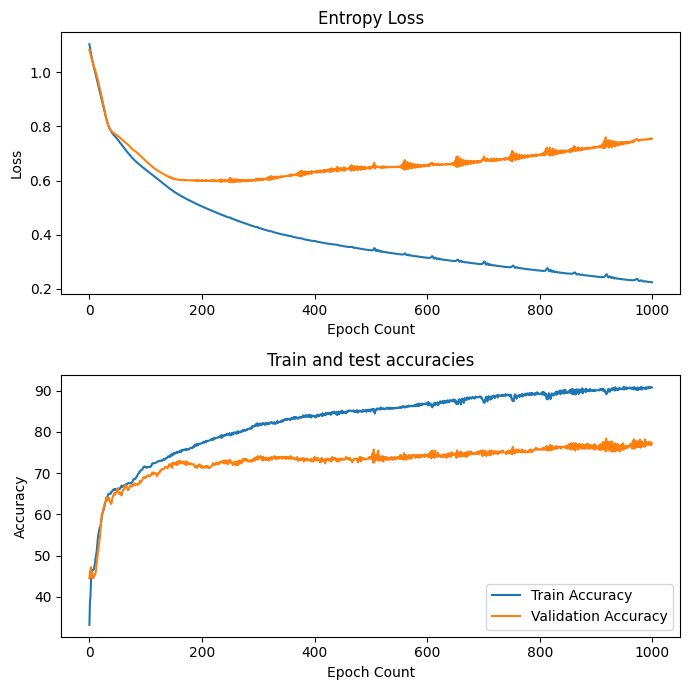

In [156]:
with open('main.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

# Run data preprocessing code-block to get new data
get_ipython().run_cell(nb.cells[4].source)

network = NeuralNetwork(14,3, "Tanh")
network.run(1000, 0.001)
network.display_metrics()

## Grid search for activation functions and learning rate

<Axes: >

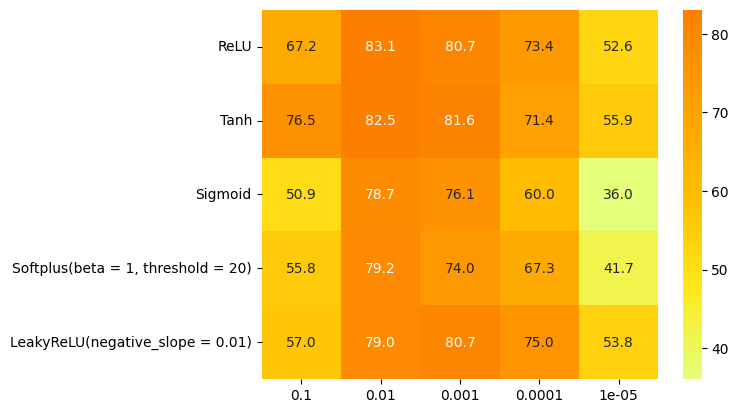

In [157]:
functions = ["ReLU", "Tanh", "Sigmoid", "Softplus(beta = 1, threshold = 20)", "LeakyReLU(negative_slope = 0.01)"]
# functions = ["Sigmoid"]
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
epoch_count = 1000
run_count = 5

temp_data = np.zeros((5,5))

with open('main.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

    for f in range(len(functions)):
        # network = NeuralNetwork(14,3, functions[f])
        for l in range(len(learning_rates)):
            temp_score = 0
            # print(functions[f], learning_rates[l])
            for i in range(run_count):
                # New data for each run
                get_ipython().run_cell(nb.cells[4].source) 
                network = NeuralNetwork(14,3, functions[f])
                temp_score += network.run(epoch_count, learning_rates[l])
            
            temp_data[f][l] = temp_score / 5
            # print(temp_data[f][l])

data = pd.DataFrame(temp_data, index=functions, columns=learning_rates)

sns.heatmap(data, annot=True, fmt=".1f", cmap="Wistia")